# CNN model (from "Fast Solar Image Classification Using Deep Learning and its Importance for Automation in Solar Physics" - Convolutional neural network)

## 0. Load modules


In [6]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn as nn
import torch.optim as optim
import argparse
from tqdm import tqdm


from torchvision.transforms import v2 # library to define the transforms

#!pip install torcheval  # needs to run on google colab, on local machine you can just "pip install torcheval" in the terminal
from torcheval.metrics.functional import multiclass_f1_score

# Visualization and debugging
from sklearn.metrics import confusion_matrix
import seaborn as sns
#!pip install sunpy
from sunpy.visualization.colormaps import color_tables as ct


## 1. Import the data, create the dataset, define the Dataloaders

### 1.1 Declare data path

In [7]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'

    folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_val'
    folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_val'


    #Adrien
    #folder0_path = '/content/drive/My Drive/Machine Learning/Projet/data0'
    #folder1_path = '/content/drive/My Drive/Machine Learning/Projet/data1'
    #folder0_test_path = '/content/drive/My Drive/Machine Learning/Projet/data0_test'
    #folder1_test_path = '/content/drive/My Drive/Machine Learning/Projet/data1_test'

else:
    # For local environments like VS Code
    folder0_path = './data0'
    folder1_path = './data1'
    folder0_test_path = './data0_test'
    folder1_test_path = './data1_test'

### 1.2 Declare the class and the transforms

In [8]:
class NPZDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir

        # in self.files, only add f if it has 30 samples
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = transform

    # Check if the file has 30 samples, if not, don't include it in self.files (see above)
    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']

        # Rearrange dimensions to (30, 166, 166) for PyTorch (insted of (166, 166, 30))
        data = np.moveaxis(data, -1, 0)

        # assign label 1 if data is from data1, 0 if from data0
        label = 1.0 if 'data1' in self.data_dir else 0.0
        return torch.from_numpy(data).float(), label

In [17]:
mean = 51.6644
std = 62.7087

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()

    #v2.RandomResizedCrop(size=(55, 55)),                                          # weird pixelized img, we don't see the jet well sometimes
    v2.RandomAffine(degrees=(-90,90), translate=(0.3, 0.3), scale=(0.8, 1.2)),    # good+useful if future sequences are not well cut out, moves the jet around the img
    #v2.RandomHorizontalFlip(p=0.4),                                               # just flips the image, no big difference
    #v2.RandomVerticalFlip(p=0.4),                                                 # same
    v2.RandomRotation(degrees=(-90,90)),                                          # rotation, jet stays at the center of the image
    #v2.RandomZoomOut(side_range=(1,3), p=0.4),                                    # makes the jet smaller and not necessarely centered

    v2.Normalize((mean,), (std,)),
    # add other transforms if needed
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()
    v2.Normalize((mean,), (std,)),
])

### 1.3 Get the data, declare the Dataloaders

In [10]:
train_data1 = NPZDataset(folder1_path, transform=train_transform)
train_data0 = NPZDataset(folder0_path, transform=train_transform)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, transform=test_transform)
test_data0 = NPZDataset(folder0_test_path, transform=test_transform)
test_data = torch.utils.data.ConcatDataset([test_data1, test_data0])


Check the device

In [14]:
device = torch.device("cpu")
print("Current device:", device)

# Switch to CUDA:0 if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Switched to CUDA:0")
else:
    print("CUDA is not available on this device.")


Current device: cpu
CUDA is not available on this device.


Visualize transforms: shows 5 images (10-15 of a sequence) of a chosen sequence in the data. The transform shown is the train_transform defined 2 cells above

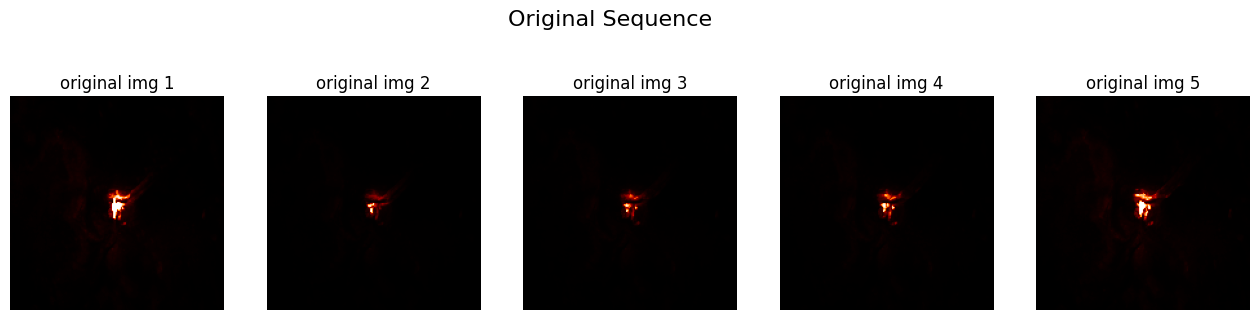

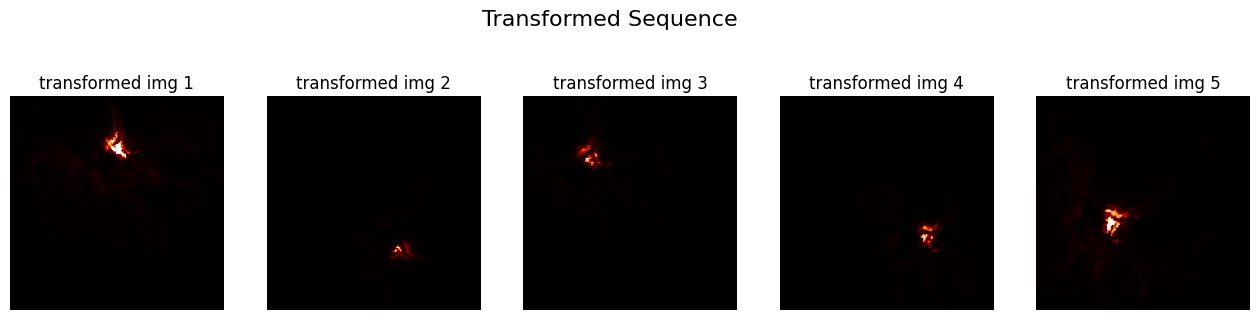

In [18]:
idx = 67 # index of image to visualize
sample_sequence, _ = train_data[idx]
original_sequence = np.moveaxis(sample_sequence.numpy(), 0, -1)  # Move axes back for visualization

# Display the original sequence

plt.figure(figsize=(16, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(original_sequence[:, :, 10+i], cmap='sdoaia304')
    plt.title(f'original img {i + 1}')
    plt.axis('off')

plt.suptitle('Original Sequence', fontsize=16)

# Plot the transformed sequence

plt.figure(figsize=(16, 4))
i = 0

for image in sample_sequence[10:15]:
    plt.subplot(1, 5, i + 1)
    trans = train_transform(image)
    plt.imshow(trans.squeeze(), cmap='sdoaia304')
    plt.title(f'transformed img {i + 1}')
    plt.axis('off')
    i += 1

plt.suptitle('Transformed Sequence', fontsize=16)
plt.show()

## 2. Define the CNN

In [19]:
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal_

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(12800,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,2)
        )

        for m in self.modules():
            if not CNN:
                kaiming_normal_(m.weight,nonlinearity="relu")#Kaiming to initialize the weights

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

## 3. Define the training and validation functions

In [22]:
def train_epoch(model,device,data_loader,optimizer,epoch,criterion,scheduler):
    metrics="yes"
    model.train()

    for i, (images, labels) in tqdm(enumerate(data_loader),desc="Epoch no."+str(epoch)): #here the images are the pytorch tensor and labels are long 1 or 0
        images, labels = images.to(device), labels.long().to(device) #Give data and label to device (model already done above)
        optimizer.zero_grad() #must zero the gradients in the optimiser since backward() accumulates gradients and this stops mixing of values between batches
        output = model(images) #feeds the data through the network
        loss = criterion(output,labels) #finds the distance in the loss space between predicted values and actual values
        loss.backward() #backpropagation of the loss
        optimizer.step()

        #Metrics
        if metrics=="yes":
          loss_history_train.append(loss.item())

          pred = output.argmax(dim=1, keepdim=True)
          correct = pred.eq(labels.view_as(pred)).sum().item()
          accuracy_float = correct / len(images)
          acc_history_train.append(accuracy_float)

    scheduler.step()
    lr_history_train.append(scheduler.get_last_lr()[0])

In [23]:
def validate(model,device,data_loader,epoch,criterion):
    model.eval()
    total, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.long().to(device)
            output = model(images)
            _, predicted = torch.max(output.data,1) #gives the max output index (that is our label)

            #Metrics
            total += labels.size(0)
            correct += (predicted == labels).sum()

            test_loss += criterion(output, labels).item() * len(images)
    print("Test Accuracy of the model on the test images: %f %% on epoch %d" % (100 * correct / total, epoch))

    #Metrics
    acc_history_test.append(correct / total)

    test_loss /= len(data_loader.dataset)
    loss_history_test.append(test_loss)

In [24]:
#Model
model = CNN() #creates an instance of the CNN

#Hyperparameters
num_epochs=100   #by performing cross validation on bach and lr parameters : batch_size=2 and lr=1e-4 (Note : Learning rate can go even lower) , if we want to increase batch size we need to increase learning rate probably
batch_size=2

#Loading in consequence

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#Other Hyperparameters

criterion = nn.CrossEntropyLoss()


"""
optimizer_kwargs = dict(
    lr=1e-4,
    weight_decay=1e-3,
)

optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
"""

optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9,nesterov=True)#Seems better optimizer than Adam for less epochs, we can increase lr as we are using scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR( #I think we don't need it for our model but still working, designed to adapt the learning rate during epochs
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )


#Parameters and Metrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_history_train=[]
lr_history_train=[]
acc_history_train=[]

acc_history_test=[]
loss_history_test=[]

model.to(device)

for i in tqdm(range(1,num_epochs+1)):
  train_epoch(model,device,train_loader,optimizer,i,criterion, scheduler)
  validate(model,device,test_loader,i, criterion)
  print(acc_history_test,loss_history_test)

cpu


Epoch no.1: 600it [06:19,  1.58it/s]/s]
  1%|          | 1/100 [06:42<11:04:28, 402.72s/it]

Test Accuracy of the model on the test images: 60.769230 % on epoch 1
[tensor(0.6077)] [0.6530765634316664]


Epoch no.2: 600it [05:56,  1.69it/s]
  2%|▏         | 2/100 [13:02<10:35:32, 389.11s/it]

Test Accuracy of the model on the test images: 52.307693 % on epoch 2
[tensor(0.6077), tensor(0.5231)] [0.6530765634316664, 0.8659466349161589]


Epoch no.3: 600it [05:46,  1.73it/s]
  3%|▎         | 3/100 [19:12<10:14:53, 380.35s/it]

Test Accuracy of the model on the test images: 64.615387 % on epoch 3
[tensor(0.6077), tensor(0.5231), tensor(0.6462)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691]


Epoch no.4: 600it [05:06,  1.96it/s]
  4%|▍         | 4/100 [24:38<9:34:15, 358.91s/it] 

Test Accuracy of the model on the test images: 76.153847 % on epoch 4
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293]


Epoch no.5: 600it [04:50,  2.07it/s]
  5%|▌         | 5/100 [29:47<9:00:03, 341.09s/it]

Test Accuracy of the model on the test images: 77.692307 % on epoch 5
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016]


Epoch no.6: 600it [04:48,  2.08it/s]
  6%|▌         | 6/100 [34:55<8:36:45, 329.85s/it]

Test Accuracy of the model on the test images: 67.692307 % on epoch 6
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795]


Epoch no.7: 600it [04:50,  2.06it/s]
  7%|▋         | 7/100 [40:06<8:21:20, 323.44s/it]

Test Accuracy of the model on the test images: 79.615387 % on epoch 7
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832]


Epoch no.8: 600it [04:49,  2.07it/s]
  8%|▊         | 8/100 [45:15<8:09:03, 318.95s/it]

Test Accuracy of the model on the test images: 75.000000 % on epoch 8
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474]


Epoch no.9: 600it [04:48,  2.08it/s]
  9%|▉         | 9/100 [50:23<7:58:44, 315.65s/it]

Test Accuracy of the model on the test images: 72.307693 % on epoch 9
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693]


Epoch no.10: 600it [04:49,  2.08it/s]
 10%|█         | 10/100 [55:32<7:50:06, 313.40s/it]

Test Accuracy of the model on the test images: 63.846153 % on epoch 10
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447]


Epoch no.11: 600it [04:50,  2.07it/s]
 11%|█         | 11/100 [1:00:41<7:43:14, 312.30s/it]

Test Accuracy of the model on the test images: 82.307693 % on epoch 11
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738]


Epoch no.12: 600it [04:51,  2.06it/s]
 12%|█▏        | 12/100 [1:05:52<7:37:20, 311.83s/it]

Test Accuracy of the model on the test images: 81.923080 % on epoch 12
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195]


Epoch no.13: 600it [04:51,  2.06it/s]
 13%|█▎        | 13/100 [1:11:03<7:31:32, 311.41s/it]

Test Accuracy of the model on the test images: 74.615387 % on epoch 13
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876]


Epoch no.14: 600it [04:51,  2.06it/s]
 14%|█▍        | 14/100 [1:16:13<7:25:48, 311.02s/it]

Test Accuracy of the model on the test images: 87.692307 % on epoch 14
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265]


Epoch no.15: 600it [04:49,  2.07it/s]
 15%|█▌        | 15/100 [1:21:21<7:19:28, 310.22s/it]

Test Accuracy of the model on the test images: 84.230766 % on epoch 15
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005]


Epoch no.16: 600it [04:48,  2.08it/s]
 16%|█▌        | 16/100 [1:26:29<7:13:26, 309.60s/it]

Test Accuracy of the model on the test images: 81.923080 % on epoch 16
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376]


Epoch no.17: 600it [04:51,  2.06it/s]
 17%|█▋        | 17/100 [1:31:40<7:08:40, 309.88s/it]

Test Accuracy of the model on the test images: 77.307693 % on epoch 17
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046]


Epoch no.18: 600it [04:48,  2.08it/s]
 18%|█▊        | 18/100 [1:36:48<7:02:43, 309.31s/it]

Test Accuracy of the model on the test images: 86.153847 % on epoch 18
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556]


Epoch no.19: 600it [04:47,  2.09it/s]
 19%|█▉        | 19/100 [1:41:54<6:56:18, 308.37s/it]

Test Accuracy of the model on the test images: 83.461540 % on epoch 19
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459]


Epoch no.20: 600it [04:46,  2.10it/s]
 20%|██        | 20/100 [1:47:00<6:50:03, 307.54s/it]

Test Accuracy of the model on the test images: 85.769234 % on epoch 20
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542]


Epoch no.21: 600it [04:47,  2.09it/s]
 21%|██        | 21/100 [1:52:07<6:44:42, 307.38s/it]

Test Accuracy of the model on the test images: 88.461540 % on epoch 21
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181]


Epoch no.22: 600it [04:47,  2.08it/s]
 22%|██▏       | 22/100 [1:57:14<6:39:31, 307.33s/it]

Test Accuracy of the model on the test images: 79.230766 % on epoch 22
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665]


Epoch no.23: 600it [04:51,  2.06it/s]
 23%|██▎       | 23/100 [2:02:24<6:35:41, 308.33s/it]

Test Accuracy of the model on the test images: 86.538460 % on epoch 23
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665, 0.4725228521238731]


Epoch no.24: 600it [04:50,  2.06it/s]
 24%|██▍       | 24/100 [2:07:35<6:31:13, 308.87s/it]

Test Accuracy of the model on the test images: 84.230766 % on epoch 24
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665, 0.4725228521238731, 0.5756113862027771]


Epoch no.25: 600it [04:50,  2.07it/s]
 25%|██▌       | 25/100 [2:12:45<6:26:29, 309.19s/it]

Test Accuracy of the model on the test images: 84.230766 % on epoch 25
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665, 0.4725228521238731, 0.5756113862027771, 0.3952218822400587]


Epoch no.26: 600it [04:45,  2.10it/s]
 26%|██▌       | 26/100 [2:17:49<6:19:45, 307.91s/it]

Test Accuracy of the model on the test images: 85.769234 % on epoch 26
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665, 0.4725228521238731, 0.5756113862027771, 0.3952218822400587, 0.48339006294

Epoch no.27: 600it [04:45,  2.10it/s]
 27%|██▋       | 27/100 [2:22:55<6:13:35, 307.07s/it]

Test Accuracy of the model on the test images: 86.538460 % on epoch 27
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665, 0.4725228521238731, 0.5756113862027771, 0.395221882240058

Epoch no.28: 600it [04:47,  2.09it/s]
 28%|██▊       | 28/100 [2:28:01<6:08:18, 306.93s/it]

Test Accuracy of the model on the test images: 83.846153 % on epoch 28
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665, 0.4725228521238731, 0.5756113862027771, 0

Epoch no.29: 600it [04:48,  2.08it/s]
 29%|██▉       | 29/100 [2:33:09<6:03:24, 307.10s/it]

Test Accuracy of the model on the test images: 74.615387 % on epoch 29
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665, 0.4725228521238731, 0.575

Epoch no.30: 600it [04:47,  2.08it/s]
 30%|███       | 30/100 [2:38:16<5:58:17, 307.10s/it]

Test Accuracy of the model on the test images: 89.230766 % on epoch 30
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.5976561686465665, 0.4725228

Epoch no.31: 600it [04:47,  2.09it/s]
 31%|███       | 31/100 [2:43:22<5:52:59, 306.94s/it]

Test Accuracy of the model on the test images: 82.692307 % on epoch 31
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.6212164971855181, 0.59765616864

Epoch no.32: 600it [04:46,  2.09it/s]
 32%|███▏      | 32/100 [2:48:29<5:47:38, 306.74s/it]

Test Accuracy of the model on the test images: 85.384613 % on epoch 32
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0.621216497185518

Epoch no.33: 600it [04:48,  2.08it/s]
 33%|███▎      | 33/100 [2:53:36<5:42:47, 306.97s/it]

Test Accuracy of the model on the test images: 75.000000 % on epoch 33
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.477755413996542, 0

Epoch no.34: 600it [04:49,  2.07it/s]
 34%|███▍      | 34/100 [2:58:45<5:38:22, 307.62s/it]

Test Accuracy of the model on the test images: 85.769234 % on epoch 34
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.4578066685473459, 0.47

Epoch no.35: 600it [04:48,  2.08it/s]
 35%|███▌      | 35/100 [3:03:53<5:33:21, 307.72s/it]

Test Accuracy of the model on the test images: 81.923080 % on epoch 35
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855435556, 0.457806

Epoch no.36: 600it [04:48,  2.08it/s]
 36%|███▌      | 36/100 [3:09:01<5:28:11, 307.68s/it]

Test Accuracy of the model on the test images: 86.538460 % on epoch 36
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.5615590348036046, 0.3898649855

Epoch no.37: 600it [04:49,  2.07it/s]
 37%|███▋      | 37/100 [3:14:10<5:23:29, 308.08s/it]

Test Accuracy of the model on the test images: 84.615387 % on epoch 37
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 0.56155903480360

Epoch no.38: 600it [04:48,  2.08it/s]
 38%|███▊      | 38/100 [3:19:17<5:18:11, 307.93s/it]

Test Accuracy of the model on the test images: 87.307693 % on epoch 38
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.6198513809115376, 

Epoch no.39: 600it [04:50,  2.07it/s]
 39%|███▉      | 39/100 [3:24:27<5:13:40, 308.54s/it]

Test Accuracy of the model on the test images: 87.307693 % on epoch 39
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.3865650991551005, 0.61

Epoch no.40: 600it [04:50,  2.06it/s]
 40%|████      | 40/100 [3:29:38<5:09:03, 309.06s/it]

Test Accuracy of the model on the test images: 86.923080 % on epoch 40
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598937265, 0.386565

Epoch no.41: 600it [04:51,  2.06it/s]
 41%|████      | 41/100 [3:34:49<5:04:30, 309.67s/it]

Test Accuracy of the model on the test images: 85.384613 % on epoch 41
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522876, 0.495650598

Epoch no.42: 600it [04:52,  2.05it/s]
 42%|████▏     | 42/100 [3:40:00<4:59:55, 310.27s/it]

Test Accuracy of the model on the test images: 83.076920 % on epoch 42
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195, 0.5400204808522

Epoch no.43: 600it [04:50,  2.07it/s]
 43%|████▎     | 43/100 [3:45:10<4:54:32, 310.04s/it]

Test Accuracy of the model on the test images: 85.000000 % on epoch 43
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42030820259466195,

Epoch no.44: 600it [04:52,  2.05it/s]
 44%|████▍     | 44/100 [3:50:22<4:49:57, 310.67s/it]

Test Accuracy of the model on the test images: 87.307693 % on epoch 44
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.6385031079845738, 0.42

Epoch no.45: 600it [04:50,  2.07it/s]
 45%|████▌     | 45/100 [3:55:32<4:44:29, 310.35s/it]

Test Accuracy of the model on the test images: 85.769234 % on epoch 45
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969180447, 0.638503

Epoch no.46: 600it [04:49,  2.07it/s]
 46%|████▌     | 46/100 [4:00:41<4:38:57, 309.95s/it]

Test Accuracy of the model on the test images: 82.692307 % on epoch 46
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.5382773350637693, 0.7049363969

Epoch no.47: 600it [04:49,  2.07it/s]
 47%|████▋     | 47/100 [4:05:49<4:33:21, 309.46s/it]

Test Accuracy of the model on the test images: 84.615387 % on epoch 47
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 0.53827733506376

Epoch no.48: 600it [04:48,  2.08it/s]
 48%|████▊     | 48/100 [4:10:57<4:27:54, 309.12s/it]

Test Accuracy of the model on the test images: 89.230766 % on epoch 48
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.5554045046321474, 

Epoch no.49: 600it [04:49,  2.07it/s]
 49%|████▉     | 49/100 [4:16:06<4:22:34, 308.91s/it]

Test Accuracy of the model on the test images: 86.923080 % on epoch 49
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.5638352766274832, 0.55

Epoch no.50: 600it [04:49,  2.07it/s]
 50%|█████     | 50/100 [4:21:15<4:17:32, 309.05s/it]

Test Accuracy of the model on the test images: 83.076920 % on epoch 50
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889649795, 0.563835

Epoch no.51: 600it [04:50,  2.07it/s]
 51%|█████     | 51/100 [4:26:25<4:12:30, 309.20s/it]

Test Accuracy of the model on the test images: 83.076920 % on epoch 51
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.527194281320016, 0.5951599889

Epoch no.52: 600it [04:51,  2.06it/s]
 52%|█████▏    | 52/100 [4:31:35<4:07:40, 309.60s/it]

Test Accuracy of the model on the test images: 88.846153 % on epoch 52
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293, 0.5271942813200

Epoch no.53: 600it [04:52,  2.05it/s]
 53%|█████▎    | 53/100 [4:36:47<4:02:58, 310.18s/it]

Test Accuracy of the model on the test images: 89.230766 % on epoch 53
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7513601401966293,

Epoch no.54: 600it [04:48,  2.08it/s]
 54%|█████▍    | 54/100 [4:41:54<3:57:13, 309.43s/it]

Test Accuracy of the model on the test images: 85.000000 % on epoch 54
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500)] [0.6530765634316664, 0.8659466349161589, 0.6077852344283691, 0.7

Epoch no.55: 600it [04:44,  2.11it/s]
 55%|█████▌    | 55/100 [4:46:58<3:50:45, 307.67s/it]

Test Accuracy of the model on the test images: 88.461540 % on epoch 55
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846)] [0.6530765634316664, 0.8659466349161589, 0.60778

Epoch no.56: 600it [04:43,  2.11it/s]
 56%|█████▌    | 56/100 [4:52:01<3:44:37, 306.30s/it]

Test Accuracy of the model on the test images: 88.461540 % on epoch 56
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846)] [0.6530765634316664, 0.865946634

Epoch no.57: 600it [04:44,  2.11it/s]
 57%|█████▋    | 57/100 [4:57:05<3:38:54, 305.44s/it]

Test Accuracy of the model on the test images: 90.000000 % on epoch 57
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000)] [0.6530765634316

Epoch no.58: 600it [04:45,  2.10it/s]
 58%|█████▊    | 58/100 [5:02:09<3:33:38, 305.20s/it]

Test Accuracy of the model on the test images: 89.615387 % on epoch 58
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962)] 

Epoch no.59: 600it [04:45,  2.10it/s]
 59%|█████▉    | 59/100 [5:07:14<3:28:25, 305.00s/it]

Test Accuracy of the model on the test images: 87.307693 % on epoch 59
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.60: 600it [04:47,  2.09it/s]
 60%|██████    | 60/100 [5:12:20<3:23:36, 305.41s/it]

Test Accuracy of the model on the test images: 90.000000 % on epoch 60
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.61: 600it [04:48,  2.08it/s]
 61%|██████    | 61/100 [5:17:27<3:18:52, 305.97s/it]

Test Accuracy of the model on the test images: 90.384613 % on epoch 61
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.62: 600it [04:49,  2.07it/s]
 62%|██████▏   | 62/100 [5:22:36<3:14:19, 306.83s/it]

Test Accuracy of the model on the test images: 88.461540 % on epoch 62
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.63: 600it [04:50,  2.07it/s]
 63%|██████▎   | 63/100 [5:27:45<3:09:39, 307.55s/it]

Test Accuracy of the model on the test images: 90.769234 % on epoch 63
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.64: 600it [04:52,  2.05it/s]
 64%|██████▍   | 64/100 [5:32:57<3:05:13, 308.71s/it]

Test Accuracy of the model on the test images: 92.692307 % on epoch 64
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.65: 600it [04:52,  2.05it/s]
 65%|██████▌   | 65/100 [5:38:08<3:00:32, 309.51s/it]

Test Accuracy of the model on the test images: 90.384613 % on epoch 65
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.66: 600it [04:52,  2.05it/s]
 66%|██████▌   | 66/100 [5:43:20<2:55:47, 310.23s/it]

Test Accuracy of the model on the test images: 86.153847 % on epoch 66
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.67: 600it [04:49,  2.08it/s]
 67%|██████▋   | 67/100 [5:48:29<2:50:19, 309.69s/it]

Test Accuracy of the model on the test images: 83.846153 % on epoch 67
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.68: 600it [04:51,  2.06it/s]
 68%|██████▊   | 68/100 [5:53:39<2:45:21, 310.04s/it]

Test Accuracy of the model on the test images: 91.538460 % on epoch 68
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.69: 600it [04:54,  2.04it/s]
 69%|██████▉   | 69/100 [5:58:53<2:40:43, 311.08s/it]

Test Accuracy of the model on the test images: 87.692307 % on epoch 69
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.70: 600it [04:54,  2.04it/s]
 70%|███████   | 70/100 [6:04:06<2:35:54, 311.83s/it]

Test Accuracy of the model on the test images: 88.461540 % on epoch 70
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.71: 600it [04:54,  2.03it/s]
 71%|███████   | 71/100 [6:09:21<2:31:04, 312.59s/it]

Test Accuracy of the model on the test images: 86.538460 % on epoch 71
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.72: 600it [04:53,  2.04it/s]
 72%|███████▏  | 72/100 [6:14:34<2:25:56, 312.74s/it]

Test Accuracy of the model on the test images: 89.230766 % on epoch 72
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.73: 600it [04:52,  2.05it/s]
 73%|███████▎  | 73/100 [6:19:46<2:20:37, 312.50s/it]

Test Accuracy of the model on the test images: 84.615387 % on epoch 73
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.74: 600it [04:53,  2.04it/s]
 74%|███████▍  | 74/100 [6:24:59<2:15:30, 312.72s/it]

Test Accuracy of the model on the test images: 91.923080 % on epoch 74
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.75: 600it [04:54,  2.04it/s]
 75%|███████▌  | 75/100 [6:30:13<2:10:28, 313.14s/it]

Test Accuracy of the model on the test images: 90.769234 % on epoch 75
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.76: 600it [04:56,  2.03it/s]
 76%|███████▌  | 76/100 [6:35:28<2:05:29, 313.74s/it]

Test Accuracy of the model on the test images: 91.538460 % on epoch 76
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.77: 600it [04:57,  2.02it/s]
 77%|███████▋  | 77/100 [6:40:45<2:00:32, 314.47s/it]

Test Accuracy of the model on the test images: 90.384613 % on epoch 77
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.78: 600it [04:53,  2.04it/s]
 78%|███████▊  | 78/100 [6:45:57<1:55:07, 313.96s/it]

Test Accuracy of the model on the test images: 89.615387 % on epoch 78
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.79: 600it [04:53,  2.05it/s]
 79%|███████▉  | 79/100 [6:51:10<1:49:44, 313.53s/it]

Test Accuracy of the model on the test images: 91.923080 % on epoch 79
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.80: 600it [04:53,  2.04it/s]
 80%|████████  | 80/100 [6:56:23<1:44:25, 313.29s/it]

Test Accuracy of the model on the test images: 88.461540 % on epoch 80
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.81: 600it [04:54,  2.04it/s]
 81%|████████  | 81/100 [7:01:36<1:39:14, 313.40s/it]

Test Accuracy of the model on the test images: 88.461540 % on epoch 81
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.82: 600it [04:54,  2.04it/s]
 82%|████████▏ | 82/100 [7:06:50<1:34:03, 313.55s/it]

Test Accuracy of the model on the test images: 90.384613 % on epoch 82
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.83: 600it [04:54,  2.04it/s]
 83%|████████▎ | 83/100 [7:12:04<1:28:51, 313.60s/it]

Test Accuracy of the model on the test images: 90.769234 % on epoch 83
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.84: 600it [04:50,  2.07it/s]
 84%|████████▍ | 84/100 [7:17:13<1:23:16, 312.25s/it]

Test Accuracy of the model on the test images: 86.153847 % on epoch 84
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.85: 600it [04:50,  2.06it/s]
 85%|████████▌ | 85/100 [7:22:23<1:17:53, 311.57s/it]

Test Accuracy of the model on the test images: 88.076920 % on epoch 85
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.86: 600it [04:52,  2.05it/s]
 86%|████████▌ | 86/100 [7:27:35<1:12:43, 311.69s/it]

Test Accuracy of the model on the test images: 89.615387 % on epoch 86
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.87: 600it [04:52,  2.05it/s]
 87%|████████▋ | 87/100 [7:32:46<1:07:30, 311.57s/it]

Test Accuracy of the model on the test images: 88.846153 % on epoch 87
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.88: 600it [04:52,  2.05it/s]
 88%|████████▊ | 88/100 [7:37:58<1:02:19, 311.62s/it]

Test Accuracy of the model on the test images: 91.923080 % on epoch 88
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.89: 600it [04:54,  2.04it/s]
 89%|████████▉ | 89/100 [7:43:12<57:16, 312.39s/it]  

Test Accuracy of the model on the test images: 90.384613 % on epoch 89
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.90: 600it [04:55,  2.03it/s]
 90%|█████████ | 90/100 [7:48:27<52:10, 313.07s/it]

Test Accuracy of the model on the test images: 90.384613 % on epoch 90
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.91: 600it [04:54,  2.04it/s]
 91%|█████████ | 91/100 [7:53:41<47:00, 313.41s/it]

Test Accuracy of the model on the test images: 91.153847 % on epoch 91
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.92: 600it [04:58,  2.01it/s]
 92%|█████████▏| 92/100 [7:58:59<41:57, 314.65s/it]

Test Accuracy of the model on the test images: 92.307693 % on epoch 92
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.93: 600it [04:55,  2.03it/s]
 93%|█████████▎| 93/100 [8:04:13<36:43, 314.74s/it]

Test Accuracy of the model on the test images: 88.846153 % on epoch 93
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.94: 600it [04:55,  2.03it/s]
 94%|█████████▍| 94/100 [8:09:29<31:29, 314.85s/it]

Test Accuracy of the model on the test images: 91.538460 % on epoch 94
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.95: 600it [04:51,  2.06it/s]
 95%|█████████▌| 95/100 [8:14:39<26:07, 313.60s/it]

Test Accuracy of the model on the test images: 87.307693 % on epoch 95
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.96: 600it [04:47,  2.09it/s]
 96%|█████████▌| 96/100 [8:19:46<20:45, 311.47s/it]

Test Accuracy of the model on the test images: 91.538460 % on epoch 96
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.97: 600it [04:48,  2.08it/s]
 97%|█████████▋| 97/100 [8:24:54<15:31, 310.49s/it]

Test Accuracy of the model on the test images: 90.769234 % on epoch 97
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.98: 600it [04:48,  2.08it/s]
 98%|█████████▊| 98/100 [8:30:02<10:19, 309.73s/it]

Test Accuracy of the model on the test images: 90.769234 % on epoch 98
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.99: 600it [04:48,  2.08it/s]
 99%|█████████▉| 99/100 [8:35:10<05:09, 309.22s/it]

Test Accuracy of the model on the test images: 90.384613 % on epoch 99
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962), 

Epoch no.100: 600it [04:49,  2.07it/s]
100%|██████████| 100/100 [8:40:18<00:00, 312.19s/it]

Test Accuracy of the model on the test images: 90.384613 % on epoch 100
[tensor(0.6077), tensor(0.5231), tensor(0.6462), tensor(0.7615), tensor(0.7769), tensor(0.6769), tensor(0.7962), tensor(0.7500), tensor(0.7231), tensor(0.6385), tensor(0.8231), tensor(0.8192), tensor(0.7462), tensor(0.8769), tensor(0.8423), tensor(0.8192), tensor(0.7731), tensor(0.8615), tensor(0.8346), tensor(0.8577), tensor(0.8846), tensor(0.7923), tensor(0.8654), tensor(0.8423), tensor(0.8423), tensor(0.8577), tensor(0.8654), tensor(0.8385), tensor(0.7462), tensor(0.8923), tensor(0.8269), tensor(0.8538), tensor(0.7500), tensor(0.8577), tensor(0.8192), tensor(0.8654), tensor(0.8462), tensor(0.8731), tensor(0.8731), tensor(0.8692), tensor(0.8538), tensor(0.8308), tensor(0.8500), tensor(0.8731), tensor(0.8577), tensor(0.8269), tensor(0.8462), tensor(0.8923), tensor(0.8692), tensor(0.8308), tensor(0.8308), tensor(0.8885), tensor(0.8923), tensor(0.8500), tensor(0.8846), tensor(0.8846), tensor(0.9000), tensor(0.8962),

## 6. Analyze the results

60000
59901


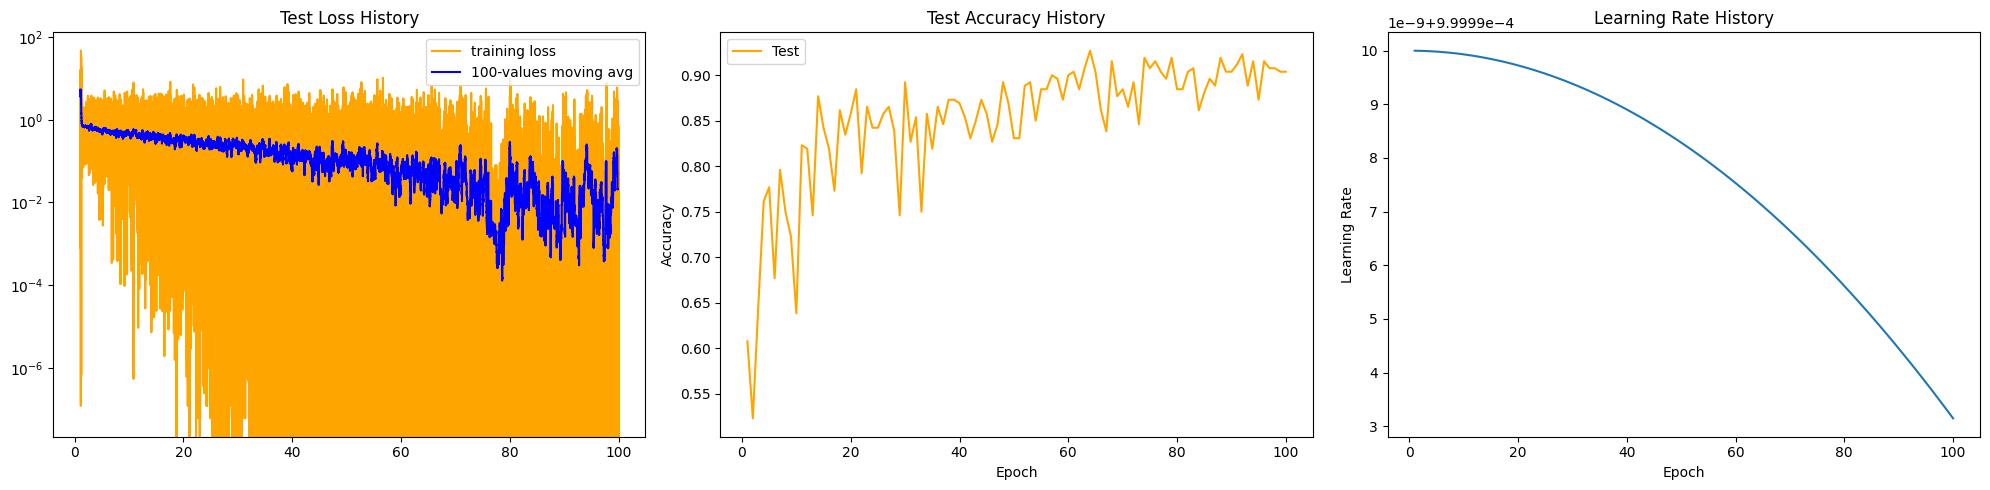

In [39]:
accuracy_history=acc_history_test.copy()
loss_history=loss_history_test
train_loss = loss_history_train.copy()

# Use numpy's convolve function to calculate the moving average
moving_avg_train = np.convolve(train_loss, np.ones(100)/100, mode='valid')
print(len(train_loss))
print(len(moving_avg_train))
"""
for i in range(len(loss_history)):
  loss_history[i]=loss_history[i].cpu().detach().numpy()"""

#for i in range(len(accuracy_history)):                           #You might need to run this if the vector is stored on cuda
#  accuracy_history[i]=accuracy_history[i].cpu().detach().numpy()

n_train = len(accuracy_history)

t_test = np.arange(1, num_epochs + 1)
t_train = np.linspace(1,num_epochs,len(loss_history_train))

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting training accuracy history
#axs[0].plot(t_train, loss_history_train, label="Train")#train accuracy doesn't make so much sense as it is a batch of 2 datapoints (easy to go from 0 to 1)
axs[0].semilogy(t_train, train_loss, color='orange', label="training loss")
axs[0].semilogy((t_train[:-99]), moving_avg_train, color='blue', label="100-values moving avg")
axs[0].legend()
axs[0].set_title('Test Loss History')

#axs[1].plot(t_train, acc_history_train, label="Train")
axs[1].plot(t_test, accuracy_history, label="Test", color='orange')
axs[1].set_title('Test Accuracy History')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(t_test, lr_history_train)
axs[2].set_title('Learning Rate History')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')



plt.tight_layout()
plt.show()


In [29]:
best_idx = np.argmax(accuracy_history)

print(f"The best validation accuracy was obtained on epoch {t_test[best_idx]} and was {accuracy_history[best_idx]:.2f} %. ")

The best validation accuracy was obtained on epoch 64 and was 0.93 %. 


## 7. Debugging tools

### a) Confusion matrix

predictions:  [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 

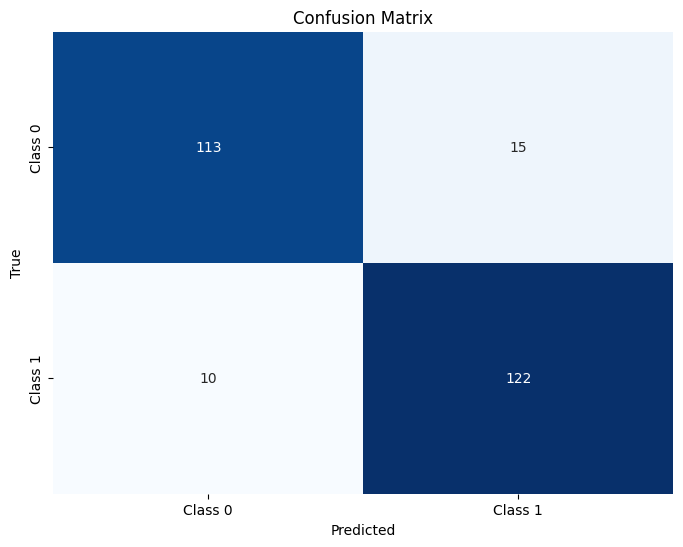

In [27]:
# Convert PyTorch tensors to NumPy arrays
model.eval()
predictions = []
labels = []
model = model.to(device)

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)
  pred = pred.cpu().numpy()
  target = target.cpu().numpy()
  target = np.array([t.item() for t in target], dtype=float)
  target = np.array(target, dtype=float)
  predictions.extend(pred)
  labels.extend(target)

print("predictions: ", predictions)
print("labels: ", labels)


# Compute confusion matrix using scikit-learn
cm = confusion_matrix(labels, predictions)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### b) Visualize misclassified images

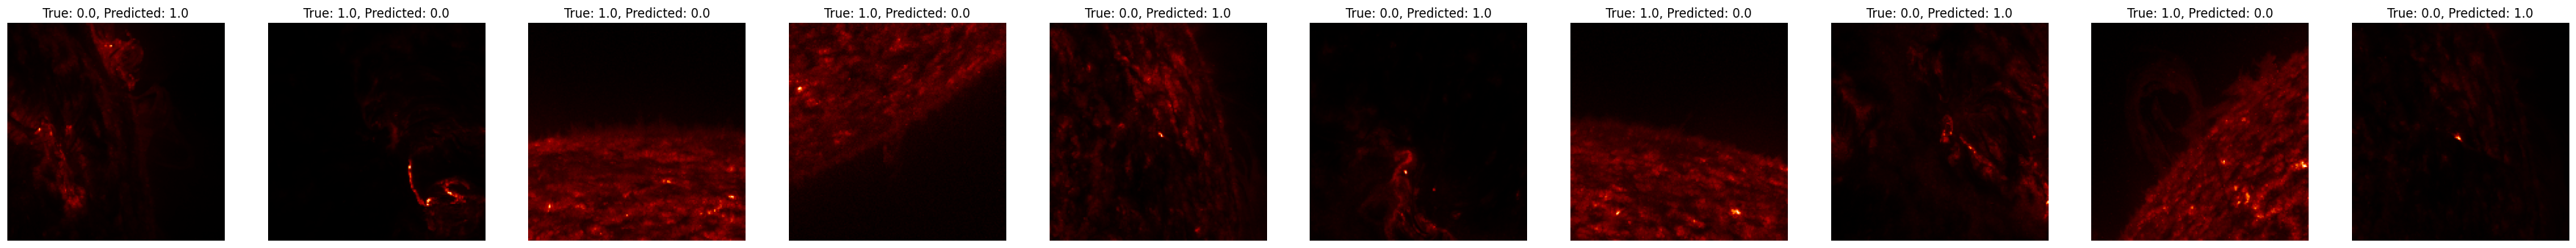

In [28]:
# Set the model to evaluation mode
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

misclassified_images = []
true_labels = []
predicted_labels = []

# Iterate through the test set
for data, target in test_loader:
    # Forward pass
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

    # Identify misclassified images
    misclassified_mask = pred != target
    misclassified_images.extend(data[misclassified_mask])
    true_labels.extend(target[misclassified_mask])
    predicted_labels.extend(pred[misclassified_mask])

# Convert lists to PyTorch tensors
misclassified_images = torch.stack(misclassified_images)
true_labels = torch.stack(true_labels)
predicted_labels = torch.stack(predicted_labels)

# Assuming you have a function to reverse normalization if applied during data preprocessing
# Replace reverse_normalize with your actual function
# Example:
reverse_normalize = transforms.Compose([transforms.Normalize(mean=0, std=(1/62.7087)),
                                        transforms.Normalize(mean=-51.6644, std=1)])

# Display misclassified images
num_images_to_display = min(10, len(misclassified_images))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(45,6))

for i in range(num_images_to_display):
    # Assuming images are in RGB format
    image = reverse_normalize(misclassified_images[i]).cpu().numpy()
    true_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    axes[i].imshow(image[15,:,:], cmap='sdoaia304')
    axes[i].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[i].axis('off')

plt.show()
